In [1]:
from utils import *
sns.set(style="darkgrid")

In [2]:
set_seed(0)

Random seed set as 0


In [3]:
X_train = np.load('./classification_data/X_train.npy')
X_val = np.load('./classification_data/X_val.npy')
X_test = np.load('./classification_data/X_test.npy')
y_train = np.load('./classification_data/y_train.npy')
y_val = np.load('./classification_data/y_val.npy')
y_test = np.load('./classification_data/y_test.npy')
bcu_samples = np.load('./classification_data/bcu_samples.npy')

In [4]:
def train_temp(model = None, mode = None, X_train= None, y_train= None, X_val = None, y_val = None, epochs = None):
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
    # Train the model
    model.fit(
        X_train,
        y_train, 
        epochs=epochs, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, y_val), 
        callbacks = [PlotLossesKeras()]
    )

In [5]:
def train(model = None, mode = None, X_train= None, y_train= None, X_val = None, y_val = None, epochs = None):
    model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
    checkpoint_path = './greedy_ckpts/' + 'weights_epoch_{epoch:02d}.h5'
    ckpt = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
        mode='min',
        save_freq='epoch'
    )
    # Train the model
    model.fit(
        X_train,
        y_train, 
        epochs=epochs, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, y_val), 
        callbacks = [PlotLossesKeras(), ckpt]
    )

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

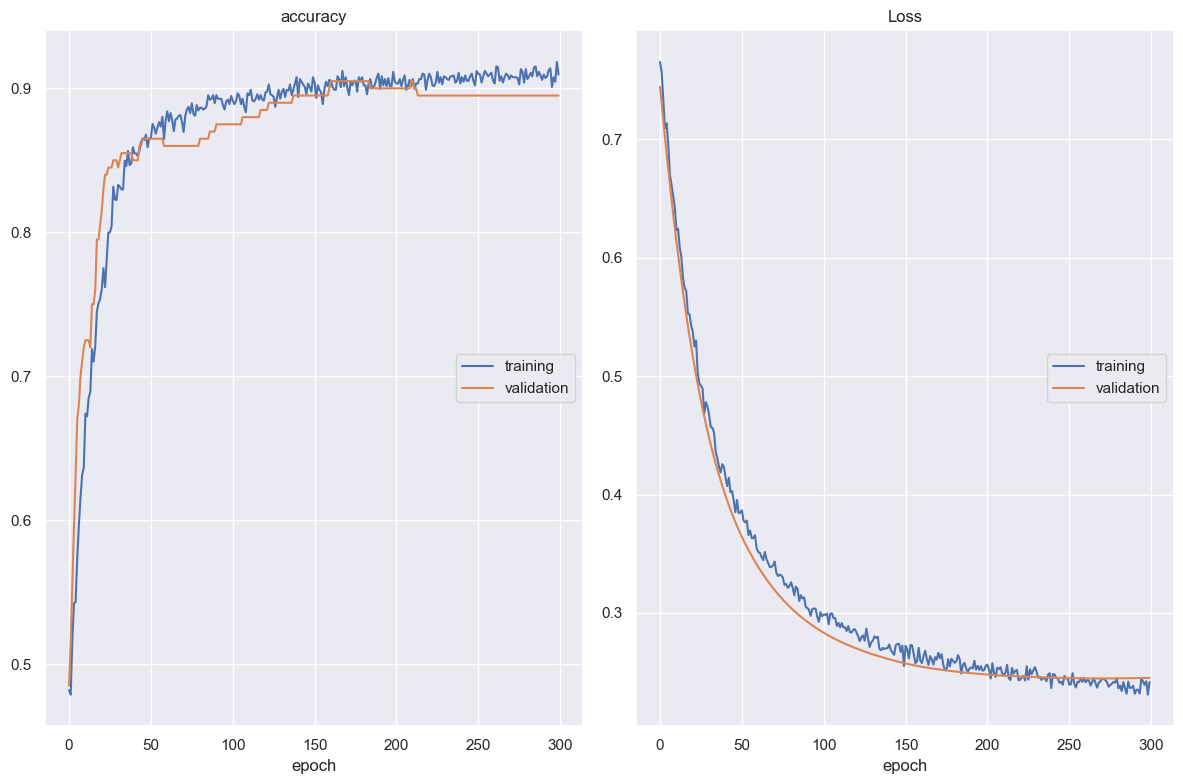

accuracy
	training         	 (min:    0.479, max:    0.918, cur:    0.910)
	validation       	 (min:    0.485, max:    0.905, cur:    0.895)
Loss
	training         	 (min:    0.231, max:    0.766, cur:    0.242)
	validation       	 (min:    0.245, max:    0.745, cur:    0.245)


In [7]:
train_temp(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=300
)

In [5]:
def remove_output_layer(model = None):
    output_layer = model.layers[-1]
    model.pop()
    for layer in model.layers:
        layer.trainable = False
    
    return model, output_layer

In [6]:
model, output_layer = remove_output_layer(model = model)
model.add(tf.keras.layers.Dense(32, activation='relu', name='Hidden-Layer-2'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 2,625
Trainable params: 2,113
Non-trainable params: 512
_________________________________________________________________


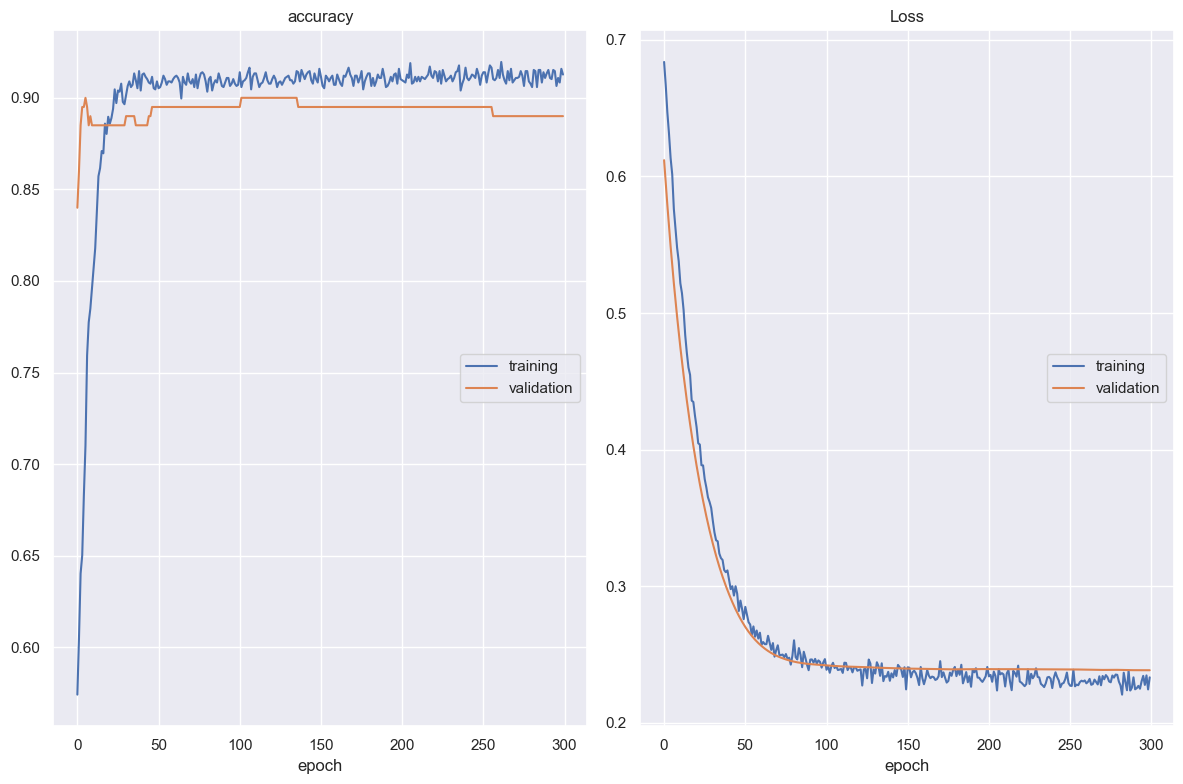

accuracy
	training         	 (min:    0.574, max:    0.920, cur:    0.913)
	validation       	 (min:    0.840, max:    0.900, cur:    0.890)
Loss
	training         	 (min:    0.221, max:    0.684, cur:    0.233)
	validation       	 (min:    0.238, max:    0.612, cur:    0.238)


In [10]:
train_temp(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=300
)

In [7]:
model, output_layer = remove_output_layer(model = model)
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                512       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
Hidden-Layer-2 (Dense)       (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 2,625
Trainable params: 33
Non-trainable params: 2,592
_________________________________________________________________


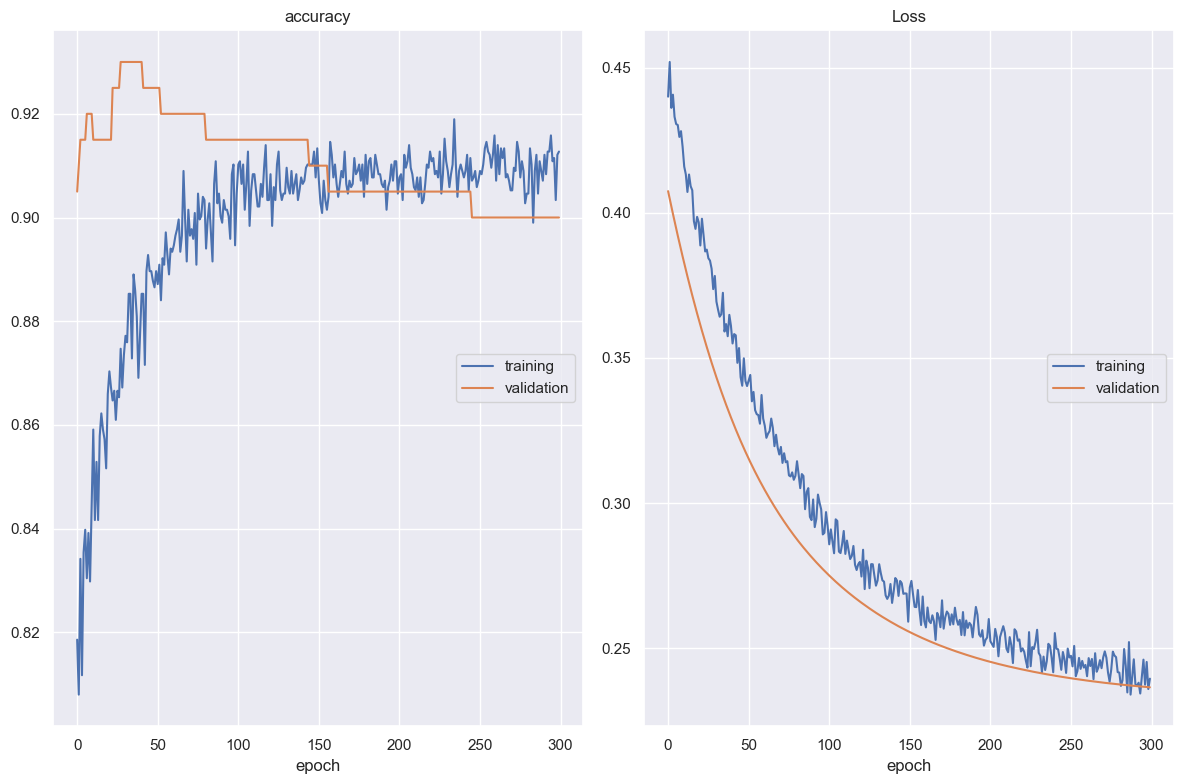

accuracy
	training         	 (min:    0.808, max:    0.919, cur:    0.913)
	validation       	 (min:    0.900, max:    0.930, cur:    0.900)
Loss
	training         	 (min:    0.234, max:    0.452, cur:    0.239)
	validation       	 (min:    0.236, max:    0.407, cur:    0.236)

Epoch 00300: saving model to ./greedy_ckpts\weights_epoch_300.h5


In [12]:
train(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val,
    epochs=300
)

In [13]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
best_auc = 0
best_accuracy = 0
best_f1 = 0
best_f1_0 = 0
best_f1_1 = 0
best_precision = 0
best_pr_0 = 0
best_pr_1 = 0
best_recall = 0
best_r0 = 0
best_r1 = 0
best_weights = {
    'auc': None, 
    'accuracy': None, 
    'f1':None, 
    'f1_0':None, 
    'f1_1':None,
    'precision': None,
    'r0': None,
    'r1': None,
    'pr_0':None,
    'pr_1':None,
    'recall': None
}

for epoch in tqdm(range(len(os.listdir('./greedy_ckpts/')))):
    weights_path = f"./greedy_ckpts/weights_epoch_{epoch+1:02d}.h5"
    model.load_weights(weights_path)
    
    # Evaluate the model
    predictions = model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, np.round(predictions))
    f1_0 = f1_score(y_test, np.round(predictions), pos_label=0)
    f1_1 = f1_score(y_test, np.round(predictions), pos_label=1)
    f1 = f1_score(y_test, np.round(predictions), average='weighted')
    precision = precision_score(y_test, np.round(predictions), average='weighted')
    pr_0 = precision_score(y_test, np.round(predictions), pos_label=0)
    pr_1 = precision_score(y_test, np.round(predictions), pos_label=1)
    recall = recall_score(y_test, np.round(predictions), average='weighted')
    r0 = recall_score(y_test, np.round(predictions), pos_label=0)
    r1 = recall_score(y_test, np.round(predictions), pos_label=1)
    
    #accuracy = standard_nn_classifier.evaluate(X_test, y_test, verbose=0)[1]
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_weights['auc'] = weights_path
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights['accuracy'] = weights_path
    if f1 > best_f1:
        best_f1 = f1
        best_weights['f1'] = weights_path
    if f1_0 > best_f1_0:
        best_f1_0 = f1_0
        best_weights['f1_0'] = weights_path
    if f1_1 > best_f1_1:
        best_f1_1 = f1_1
        best_weights['f1_1'] = weights_path
    if precision > best_precision:
        best_precision = precision
        best_weights['precision'] = weights_path
    if pr_0 > best_pr_0:
        best_pr_0 = pr_0 
        best_weights['pr_0'] = weights_path
    if pr_1 > best_pr_1:
        best_pr_1 = pr_1 
        best_weights['pr_1'] = weights_path
    if r0 > best_r0:
        best_r0 = r0 
        best_weights['r0'] = weights_path
    if r1 > best_r1:
        best_r1 = r1 
        best_weights['r1'] = weights_path
    if recall > best_recall:
        best_recall = recall
        best_weights['recall'] = weights_path

print("Best ROC AUC:", round(best_auc,2))
print("Best accuracy:", round(best_accuracy,2))
print("Best PR(0):", round(best_pr_0,2))
print("Best R(0):", round(best_r0,2))
print("Best F1(0):", round(best_f1_0,2))
print("Best PR(1):", round(best_pr_1,2))
print("Best R(1):", round(best_r1,2))
print("Best F1(1):", round(best_f1_1,2))
print("Best F1:", round(best_f1,2))
print('Best precision:', round(best_precision,2))
print('Best recall:', round(best_recall,2))
print(best_weights)

100%|██████████| 300/300 [00:17<00:00, 17.15it/s]

Best ROC AUC: 0.96
Best accuracy: 0.92
Best PR(0): 0.96
Best R(0): 0.92
Best F1(0): 0.94
Best PR(1): 0.82
Best R(1): 0.92
Best F1(1): 0.86
Best F1: 0.92
Best precision: 0.92
Best recall: 0.92
{'auc': './greedy_ckpts/weights_epoch_24.h5', 'accuracy': './greedy_ckpts/weights_epoch_43.h5', 'f1': './greedy_ckpts/weights_epoch_43.h5', 'f1_0': './greedy_ckpts/weights_epoch_43.h5', 'f1_1': './greedy_ckpts/weights_epoch_43.h5', 'precision': './greedy_ckpts/weights_epoch_43.h5', 'r0': './greedy_ckpts/weights_epoch_43.h5', 'r1': './greedy_ckpts/weights_epoch_05.h5', 'pr_0': './greedy_ckpts/weights_epoch_43.h5', 'pr_1': './greedy_ckpts/weights_epoch_43.h5', 'recall': './greedy_ckpts/weights_epoch_43.h5'}


In [8]:
from sklearn.metrics import roc_auc_score, classification_report
model.load_weights('./greedy_ckpts/weights_epoch_43.h5')
predictions = model.predict(X_test)
print(roc_auc_score(y_test, predictions))
print(classification_report(y_test, np.round(predictions), digits = 3))

0.9560754356648364
              precision    recall  f1-score   support

           0      0.963     0.915     0.939       142
           1      0.818     0.915     0.864        59

    accuracy                          0.915       201
   macro avg      0.891     0.915     0.901       201
weighted avg      0.920     0.915     0.917       201



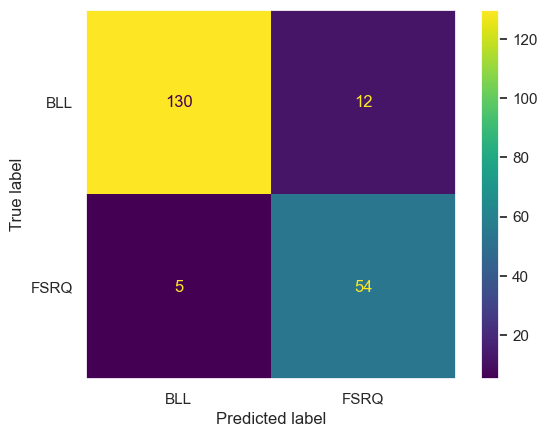

In [9]:
sns.set(style="dark")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.round(predictions))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BLL', 'FSRQ'])
disp.plot()
plt.show()

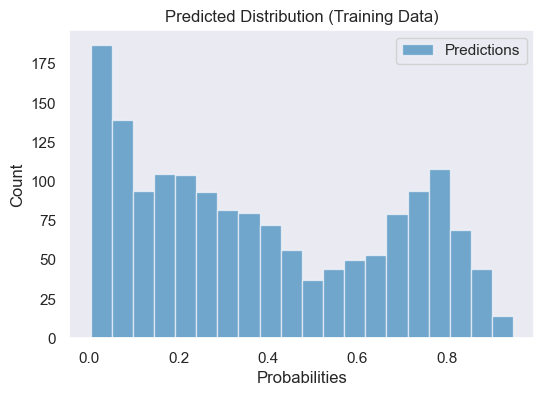

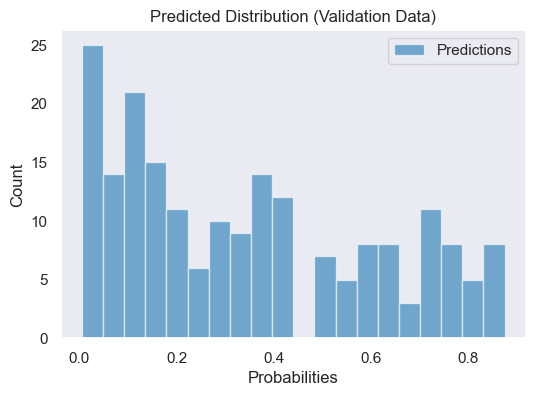

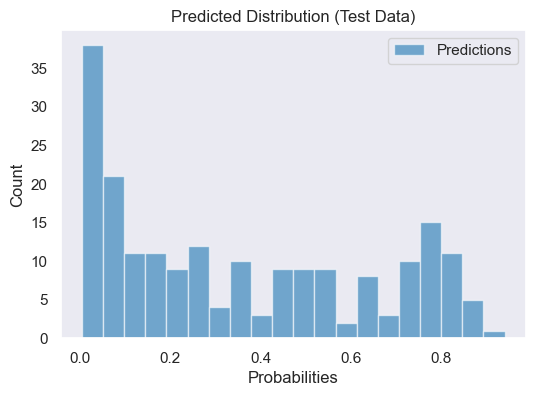

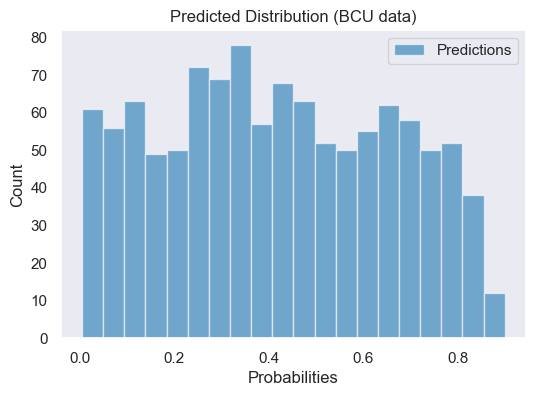

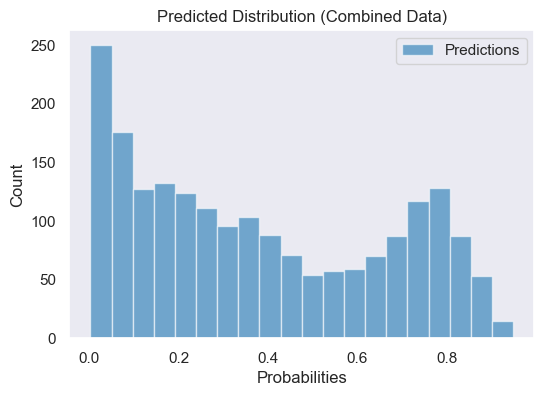

In [11]:
def plot_histograms(bin_centers, hist, label, title, bin_centers_labels=None, hist_labels=None):
    bar_width = bin_centers[1] - bin_centers[0]
    plt.bar(bin_centers, hist, width=bar_width, alpha=0.6, color='tab:blue', label=label)
    #if bin_centers_labels is not None and hist_labels is not None:
        #bar_width_labels = bin_centers_labels[1] - bin_centers_labels[0]
        #plt.bar(bin_centers_labels, hist_labels, width=bar_width_labels, alpha=0.3, color='red', label='Ground truth')
    plt.title(title)
    plt.xlabel('Probabilities')
    plt.ylabel('Count')
    plt.legend()


def create_and_plot_histograms(model, data, title):

    # Compute soft voting predictions
    predictions = model.predict(data, verbose= 0)
    # Calculate bin edges and centers
    no_of_bins = 20  # Adjust as needed
    hist_predictions, bin_edges_unknown = np.histogram(predictions, bins=no_of_bins)
    bar_width_unknown = bin_edges_unknown[1] - bin_edges_unknown[0]
    bin_centers_unknown = bin_edges_unknown[:-1] + bar_width_unknown / 2

    #hist_labels, bin_edges_labels_known = np.histogram(y, bins=no_of_bins)
    #bar_width_labels_known = bin_edges_labels_known[1] - bin_edges_labels_known[0]
    #bin_centers_labels_known = bin_edges_labels_known[:-1] + bar_width_labels_known / 2

    # Create and plot histograms
    plt.figure(figsize=(6, 4))
    plot_histograms(bin_centers_unknown, hist_predictions, 'Predictions', title)
    plt.show()

# Create and plot histograms for each dataset
create_and_plot_histograms(model, X_train,'Predicted Distribution (Training Data)')
create_and_plot_histograms(model, X_val,'Predicted Distribution (Validation Data)')
create_and_plot_histograms(model, X_test,'Predicted Distribution (Test Data)')
create_and_plot_histograms(model, bcu_samples,'Predicted Distribution (BCU data)')

combined_X = np.vstack((X_train, X_val, X_test))
create_and_plot_histograms(model, combined_X,'Predicted Distribution (Combined Data)')


In [20]:
sns.set(style="darkgrid")
auto_encoder_model = tf.keras.Sequential()
auto_encoder_model.add(tf.keras.layers.Dense(64, activation='relu', input_shape = (X_train.shape[1],)))
auto_encoder_model.add(tf.keras.layers.Dropout(0.5))
auto_encoder_model.add(tf.keras.layers.Dense(X_train.shape[1], activation='linear'))

auto_encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 455       
Total params: 967
Trainable params: 967
Non-trainable params: 0
_________________________________________________________________


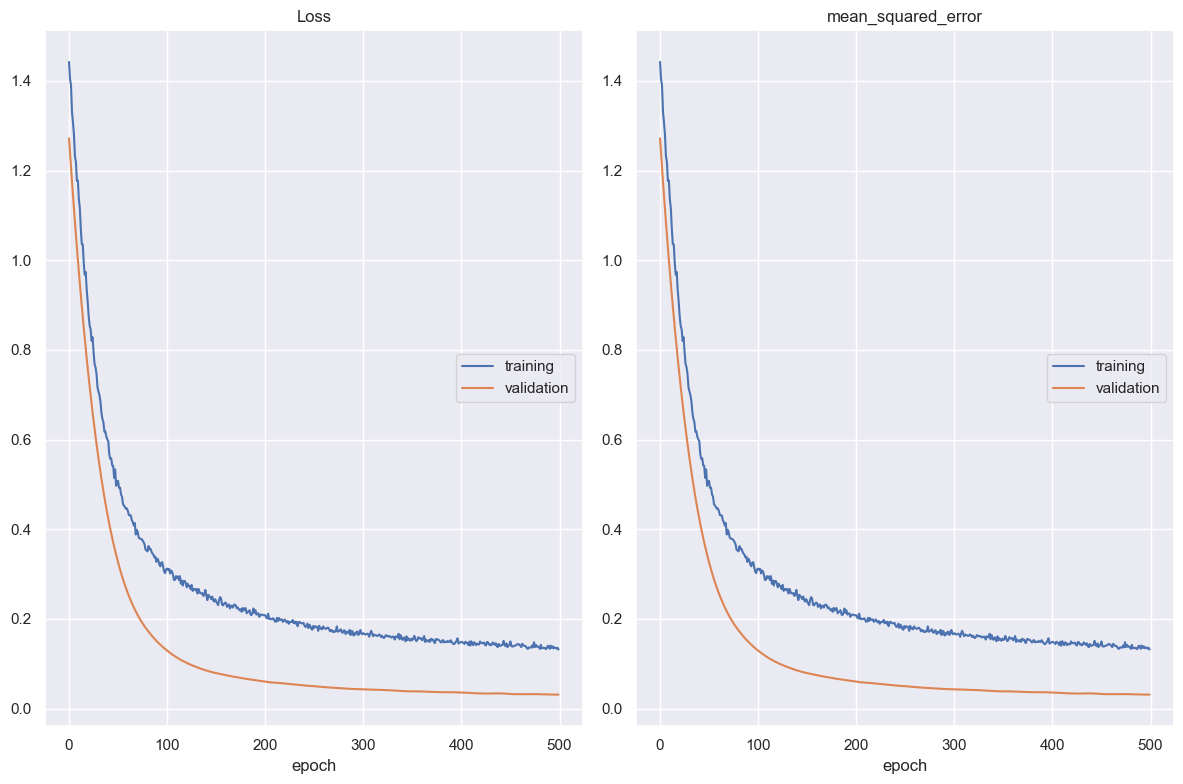

Loss
	training         	 (min:    0.132, max:    1.442, cur:    0.132)
	validation       	 (min:    0.031, max:    1.272, cur:    0.031)
mean_squared_error
	training         	 (min:    0.132, max:    1.442, cur:    0.132)
	validation       	 (min:    0.031, max:    1.272, cur:    0.031)


In [21]:
auto_encoder_model.compile(optimizer='adam', loss='mse',  metrics=['mean_squared_error'])
auto_encoder_model.fit(
        X_train,
        X_train, 
        epochs=500, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, X_val), 
        callbacks = [PlotLossesKeras()]
    )

In [22]:
auto_encoder_model, output_layer = remove_output_layer(model=auto_encoder_model)
auto_encoder_model.add(tf.keras.layers.Dense(32, activation='relu'))
auto_encoder_model.add(tf.keras.layers.Dense(X_train.shape[1], activation='linear'))

auto_encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_12 (Dense)             (None, 7)                 231       
Total params: 2,823
Trainable params: 2,311
Non-trainable params: 512
_________________________________________________________________


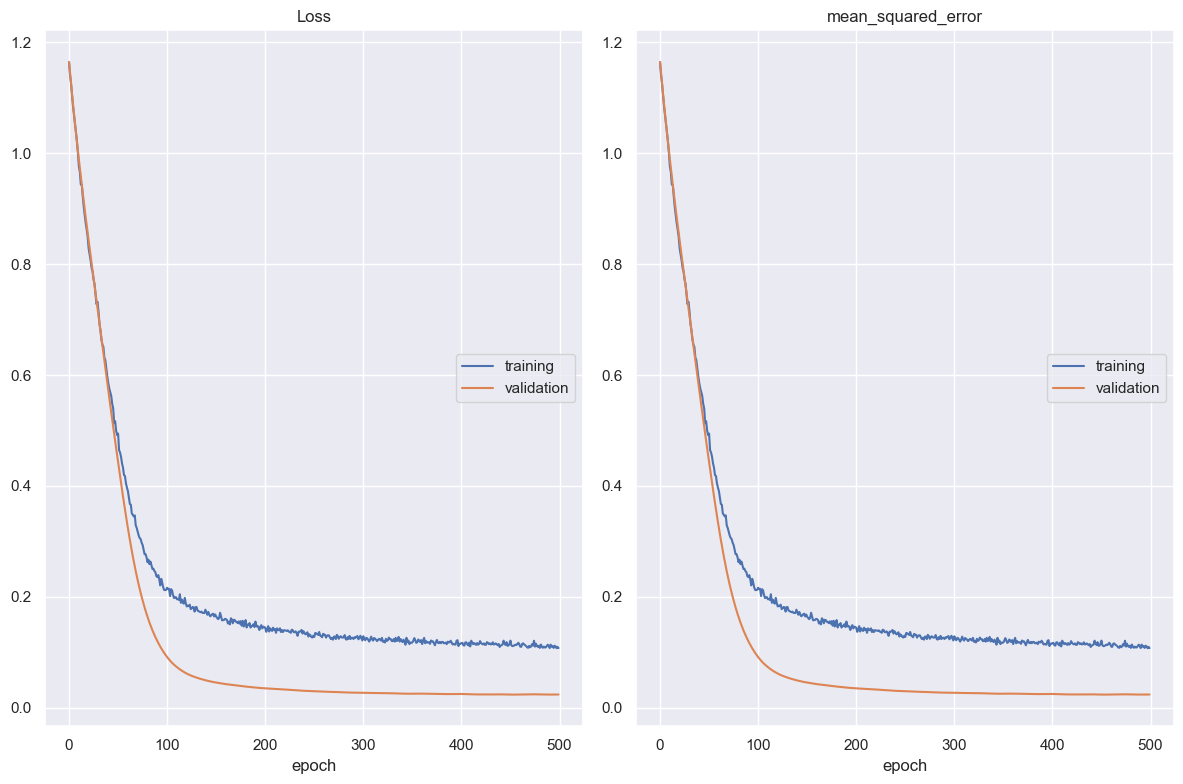

Loss
	training         	 (min:    0.108, max:    1.164, cur:    0.108)
	validation       	 (min:    0.024, max:    1.164, cur:    0.024)
mean_squared_error
	training         	 (min:    0.108, max:    1.164, cur:    0.108)
	validation       	 (min:    0.024, max:    1.164, cur:    0.024)


In [23]:
auto_encoder_model.compile(optimizer='adam', loss='mse',  metrics=['mean_squared_error'])
auto_encoder_model.fit(
        X_train,
        X_train, 
        epochs=500, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, X_val), 
        callbacks = [PlotLossesKeras()]
    )

In [24]:
auto_encoder_model, output_layer = remove_output_layer(model=auto_encoder_model)
auto_encoder_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

auto_encoder_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                512       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 33        
Total params: 2,625
Trainable params: 33
Non-trainable params: 2,592
_________________________________________________________________


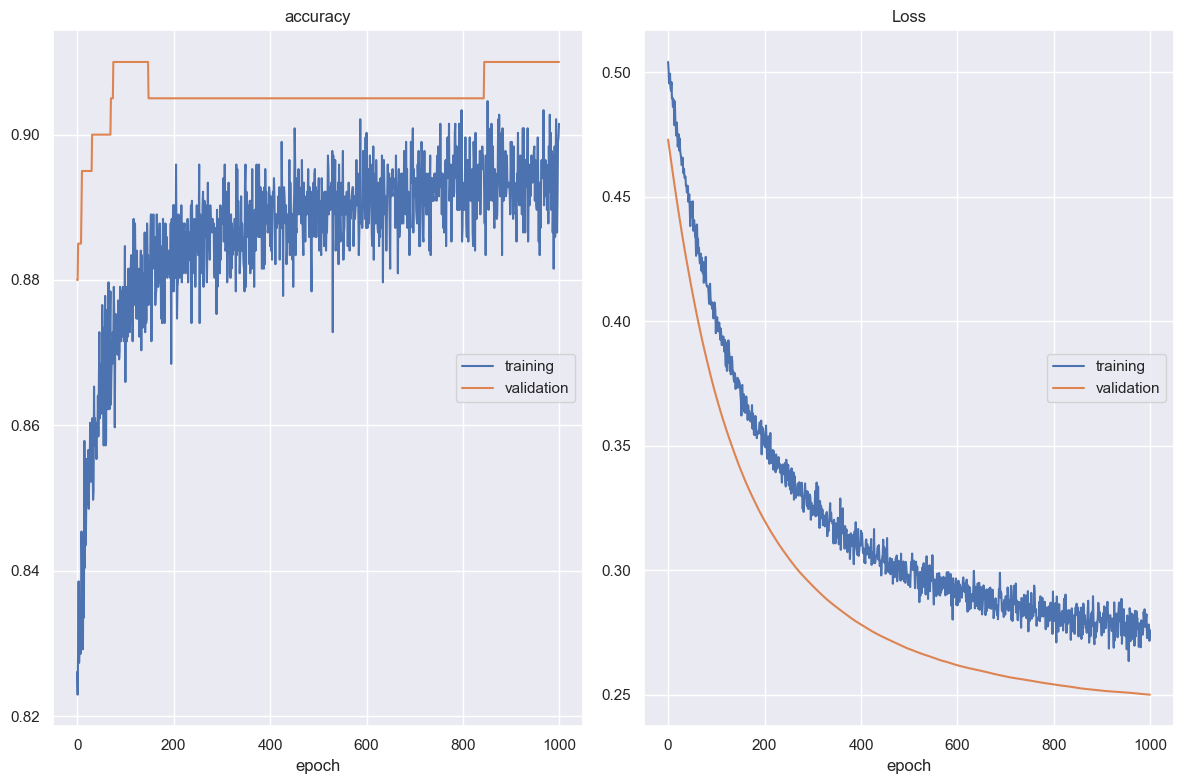

accuracy
	training         	 (min:    0.823, max:    0.905, cur:    0.901)
	validation       	 (min:    0.880, max:    0.910, cur:    0.910)
Loss
	training         	 (min:    0.263, max:    0.504, cur:    0.276)
	validation       	 (min:    0.250, max:    0.473, cur:    0.250)

Epoch 01000: saving model to ./greedy_ckpts_unsup\weights_epoch_1000.h5


In [25]:
auto_encoder_model.compile(optimizer='adam', loss='binary_crossentropy',  metrics=['accuracy'])
checkpoint_path = './greedy_ckpts_unsup/' + 'weights_epoch_{epoch:02d}.h5'
ckpt = tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_loss',
        verbose=1,
        save_best_only=False,
        save_weights_only=True,
        mode='min',
        save_freq='epoch'
    )
auto_encoder_model.fit(
        X_train,
        y_train, 
        epochs=1000, 
        batch_size=2048, 
        verbose=1, 
        validation_data=(X_val, y_val), 
        callbacks = [PlotLossesKeras(), ckpt]
    )

In [26]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, f1_score, precision_score, recall_score
from tqdm import tqdm
best_auc = 0
best_accuracy = 0
best_f1 = 0
best_f1_0 = 0
best_f1_1 = 0
best_precision = 0
best_pr_0 = 0
best_pr_1 = 0
best_recall = 0
best_r0 = 0
best_r1 = 0
best_weights = {
    'auc': None, 
    'accuracy': None, 
    'f1':None, 
    'f1_0':None, 
    'f1_1':None,
    'precision': None,
    'r0': None,
    'r1': None,
    'pr_0':None,
    'pr_1':None,
    'recall': None
}

for epoch in tqdm(range(len(os.listdir('./greedy_ckpts_unsup/')))):
    weights_path = f"./greedy_ckpts_unsup/weights_epoch_{epoch+1:02d}.h5"
    auto_encoder_model.load_weights(weights_path)
    
    # Evaluate the model
    predictions = auto_encoder_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    accuracy = accuracy_score(y_test, np.round(predictions))
    f1_0 = f1_score(y_test, np.round(predictions), pos_label=0)
    f1_1 = f1_score(y_test, np.round(predictions), pos_label=1)
    f1 = f1_score(y_test, np.round(predictions), average='weighted')
    precision = precision_score(y_test, np.round(predictions), average='weighted')
    pr_0 = precision_score(y_test, np.round(predictions), pos_label=0)
    pr_1 = precision_score(y_test, np.round(predictions), pos_label=1)
    recall = recall_score(y_test, np.round(predictions), average='weighted')
    r0 = recall_score(y_test, np.round(predictions), pos_label=0)
    r1 = recall_score(y_test, np.round(predictions), pos_label=1)
    
    #accuracy = standard_nn_classifier.evaluate(X_test, y_test, verbose=0)[1]
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_weights['auc'] = weights_path
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_weights['accuracy'] = weights_path
    if f1 > best_f1:
        best_f1 = f1
        best_weights['f1'] = weights_path
    if f1_0 > best_f1_0:
        best_f1_0 = f1_0
        best_weights['f1_0'] = weights_path
    if f1_1 > best_f1_1:
        best_f1_1 = f1_1
        best_weights['f1_1'] = weights_path
    if precision > best_precision:
        best_precision = precision
        best_weights['precision'] = weights_path
    if pr_0 > best_pr_0:
        best_pr_0 = pr_0 
        best_weights['pr_0'] = weights_path
    if pr_1 > best_pr_1:
        best_pr_1 = pr_1 
        best_weights['pr_1'] = weights_path
    if r0 > best_r0:
        best_r0 = r0 
        best_weights['r0'] = weights_path
    if r1 > best_r1:
        best_r1 = r1 
        best_weights['r1'] = weights_path
    if recall > best_recall:
        best_recall = recall
        best_weights['recall'] = weights_path

print("Best ROC AUC:", round(best_auc,2))
print("Best accuracy:", round(best_accuracy,2))
print("Best PR(0):", round(best_pr_0,2))
print("Best R(0):", round(best_r0,2))
print("Best F1(0):", round(best_f1_0,2))
print("Best PR(1):", round(best_pr_1,2))
print("Best R(1):", round(best_r1,2))
print("Best F1(1):", round(best_f1_1,2))
print("Best F1:", round(best_f1,2))
print('Best precision:', round(best_precision,2))
print('Best recall:', round(best_recall,2))
print(best_weights)

100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]

Best ROC AUC: 0.96
Best accuracy: 0.89
Best PR(0): 0.95
Best R(0): 0.89
Best F1(0): 0.92
Best PR(1): 0.77
Best R(1): 0.88
Best F1(1): 0.82
Best F1: 0.89
Best precision: 0.89
Best recall: 0.89
{'auc': './greedy_ckpts_unsup/weights_epoch_813.h5', 'accuracy': './greedy_ckpts_unsup/weights_epoch_699.h5', 'f1': './greedy_ckpts_unsup/weights_epoch_699.h5', 'f1_0': './greedy_ckpts_unsup/weights_epoch_699.h5', 'f1_1': './greedy_ckpts_unsup/weights_epoch_699.h5', 'precision': './greedy_ckpts_unsup/weights_epoch_699.h5', 'r0': './greedy_ckpts_unsup/weights_epoch_699.h5', 'r1': './greedy_ckpts_unsup/weights_epoch_230.h5', 'pr_0': './greedy_ckpts_unsup/weights_epoch_246.h5', 'pr_1': './greedy_ckpts_unsup/weights_epoch_699.h5', 'recall': './greedy_ckpts_unsup/weights_epoch_699.h5'}


In [27]:
from sklearn.metrics import roc_auc_score, classification_report
auto_encoder_model.load_weights('./greedy_ckpts_unsup/weights_epoch_699.h5')
predictions = auto_encoder_model.predict(X_test)
print(roc_auc_score(y_test, predictions))
print(classification_report(y_test, np.round(predictions), digits = 3))

0.9555979947481499
              precision    recall  f1-score   support

           0      0.941     0.894     0.917       142
           1      0.773     0.864     0.816        59

    accuracy                          0.886       201
   macro avg      0.857     0.879     0.866       201
weighted avg      0.891     0.886     0.887       201



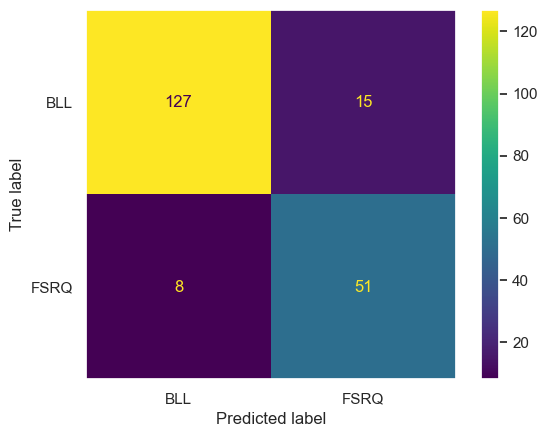

In [28]:
sns.set(style="dark")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, np.round(predictions))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['BLL', 'FSRQ'])
disp.plot()
plt.show()